# Summary Research

## Import Library & Config

In [1]:
import os
import sys
import warnings
sys.path.append(os.path.abspath('..')) 
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from src.utils import load_df, save_df, load_json, save_json
from src.modeling import get_base_models, baseline_evaluate_dataset, evaluate_dataset, compare_experiment_results
from src.tuning import tune_all_models
from src.visualization import plot_baseline_results

In [3]:
RANDOM_STATE = 42
config = {}

## Load data

In [ ]:
data = load_df("raw_FS_data.csv", "data")
data.head()

# Baseline of AIO2025 suggestion

## Base Models

In [5]:
base_models = get_base_models()
base_models

{'Linear': LinearRegression(),
 'Ridge': Ridge(random_state=42),
 'Lasso': Lasso(random_state=42),
 'Huber': HuberRegressor(),
 'Quantile': QuantileRegressor(),
 'RANSAC': RANSACRegressor(estimator=Ridge(), min_samples=0.5, random_state=42),
 'ElasticNet': ElasticNet(),
 'XGB': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_j

In [6]:
model_groups = {
    'Linear_Models': ['Ridge', 'Lasso', 'ElasticNet', 'Huber', 'Quantile'],
    'Tree_Models': ['RF', 'XGB', 'GB', 'LGBM', 'ADB'],
    'Special_Models': ['CatBoost', 'RANSAC']
}

## Run

In [7]:
baseline_results = baseline_evaluate_dataset(data, "FS_data", base_models)
baseline_results = baseline_results.sort_values(by=["Mean_RMSE"])
baseline_results


📊 Đang đánh giá dataset: FS_data

🔹 Mô hình: Linear
   Fold 1 → RMSE=33527.64, R²=0.8534
   Fold 2 → RMSE=33568.96, R²=0.8343
   Fold 3 → RMSE=53218.89, R²=0.4873
   Fold 4 → RMSE=30316.88, R²=0.8536
   Fold 5 → RMSE=25576.27, R²=0.8748

🔹 Mô hình: Ridge
   Fold 1 → RMSE=33675.85, R²=0.8521
   Fold 2 → RMSE=34084.50, R²=0.8291
   Fold 3 → RMSE=51812.93, R²=0.5141
   Fold 4 → RMSE=30197.89, R²=0.8548
   Fold 5 → RMSE=25788.37, R²=0.8728

🔹 Mô hình: Lasso
   Fold 1 → RMSE=33518.88, R²=0.8535
   Fold 2 → RMSE=33567.18, R²=0.8343
   Fold 3 → RMSE=53189.06, R²=0.4879
   Fold 4 → RMSE=30300.92, R²=0.8538
   Fold 5 → RMSE=25577.86, R²=0.8748

🔹 Mô hình: Huber
   Fold 1 → RMSE=34499.02, R²=0.8448
   Fold 2 → RMSE=33081.91, R²=0.8390
   Fold 3 → RMSE=45101.10, R²=0.6318
   Fold 4 → RMSE=30180.34, R²=0.8549
   Fold 5 → RMSE=25912.58, R²=0.8715

🔹 Mô hình: Quantile
   Fold 1 → RMSE=88667.17, R²=-0.0250
   Fold 2 → RMSE=85741.21, R²=-0.0812
   Fold 3 → RMSE=77021.13, R²=-0.0738
   Fold 4 → RMSE=8

,Dataset,Model,Mean_RMSE,Std_RMSE,Mean_R2,Std_R2
12,FS_data,CatBoost,26438.607226,4457.562029,0.882982,0.048499
10,FS_data,GB,28308.553202,7819.194984,0.855964,0.100869
11,FS_data,LGBM,29106.265825,6179.977064,0.855881,0.075264
8,FS_data,RF,30147.210919,7437.620194,0.839704,0.102743
7,FS_data,XGB,30261.657504,6782.951475,0.840364,0.091326
5,FS_data,RANSAC,33673.494961,6838.503440,0.807109,0.099228
3,FS_data,Huber,33754.989531,6387.837719,0.808432,0.088996
9,FS_data,ADB,34578.594103,5018.889700,0.800477,0.077734
1,FS_data,Ridge,35111.906738,8866.993031,0.784579,0.135962
2,FS_data,Lasso,35230.779836,9441.189417,0.780867,0.147035


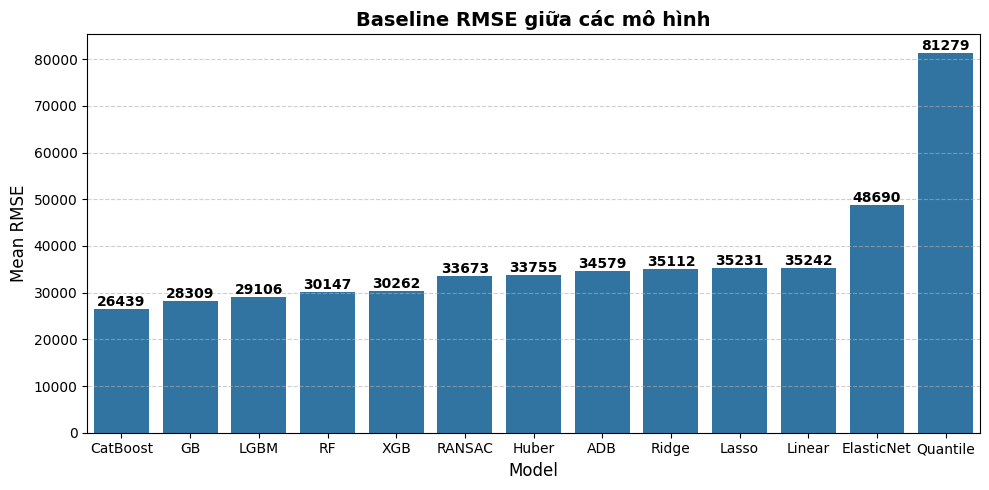

In [8]:
plot_baseline_results(baseline_results)

In [ ]:
save_df(baseline_results, "baseline_results.xlsx", "results/experiments_results")

# Quick Screening

**NOTE**:

- Đã tuning dựa trên pipeline **(MinMaxScaler(), SimpleImputer(strategy='mean'), OneHotEncoder())**

## Tuning

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import QuantileRegressor, ElasticNet

# PREPROCESSOR
df = data.copy()

X = df.drop(columns=["SalePrice"])
y = df["SalePrice"].values

tuning_groups = {
    "Robust": ["Quantile", "ElasticNet"] 
}

tuning_config = {
    "imputer_type": {"Robust": "simple"},
    "scaler_type": {"Robust": "minmax"},
    "encoder_type": {"Robust": "onehot"},
    "outlier_method": {"Robust": None},
    "input_transform": {"Robust": "org"},
    "target_transform": {"Robust": "org"},  
    "multicollinearity": {"Robust": None},
    "poly_features": {"Robust": False},
    "knn_neighbors": {"Robust": 5},
    "target_encoder_smoothing": {"Robust": 10}
}

tuning_results = tune_all_models(
    X=X,
    y=y,
    model_groups=tuning_groups,
    config=tuning_config,
    n_trials=40
)

save_df(tuning_results, "Quantile_ElasticNet_tuned.csv")
print("\nKết quả tuning:")
print(tuning_results[["Model", "Best_RMSE", "Best_Params"]])

## Load tuning params

In [ ]:
import ast
tuning_params = load_df("Quantile_ElasticNet.csv", "data")

# Gán lại tham số tối ưu
for _, row in tuning_params.iterrows():
    model_name = row["Model"]
    params_str = row["Best_Params"]

    try:
        params = ast.literal_eval(params_str)  # 👉 chuyển string sang dict
    except Exception as e:
        print(f"❌ Không parse được params cho {model_name}: {e}")
        continue

    if isinstance(params, dict) and model_name in base_models:
        base_models[model_name].set_params(**params)
        print(f"✅ Đã gán params cho {model_name}")

    else:
        print(f"⚠️ {model_name} không có trong models hoặc params không hợp lệ")

# Baseline for optimization

In [13]:
results_linear = evaluate_dataset(data, "FS_data", base_models, model_groups, group_name="Linear_Models", config={})
results_tree = evaluate_dataset(data, "FS_data", base_models, model_groups, group_name="Tree_Models", config={})
results_special = evaluate_dataset(data, "FS_data", base_models, model_groups, group_name="Special_Models", config={})
results_all = pd.concat([results_linear, results_tree, results_special], ignore_index=True)


GROUP: Linear_Models | DATASET: FS_data

Model: Ridge
   Fold 1 → RMSE=34555.67, R²=0.8443, Time=0.02s
   Fold 2 → RMSE=34059.77, R²=0.8294, Time=0.01s
   Fold 3 → RMSE=51882.85, R²=0.5128, Time=0.01s
   Fold 4 → RMSE=31165.32, R²=0.8453, Time=0.02s
   Fold 5 → RMSE=25370.28, R²=0.8769, Time=0.02s

Model: Lasso
   Fold 1 → RMSE=34332.56, R²=0.8463, Time=0.07s
   Fold 2 → RMSE=33510.39, R²=0.8348, Time=0.07s
   Fold 3 → RMSE=53414.49, R²=0.4836, Time=0.06s
   Fold 4 → RMSE=31265.71, R²=0.8443, Time=0.06s
   Fold 5 → RMSE=25434.27, R²=0.8762, Time=0.07s

Model: ElasticNet
   Fold 1 → RMSE=35876.98, R²=0.8322, Time=0.07s
   Fold 2 → RMSE=35698.97, R²=0.8126, Time=0.07s
   Fold 3 → RMSE=47266.11, R²=0.5956, Time=0.07s
   Fold 4 → RMSE=32033.69, R²=0.8366, Time=0.06s
   Fold 5 → RMSE=25987.99, R²=0.8708, Time=0.07s

Model: Huber
   Fold 1 → RMSE=33595.75, R²=0.8529, Time=0.06s
   Fold 2 → RMSE=32871.31, R²=0.8411, Time=0.07s
   Fold 3 → RMSE=44801.23, R²=0.6367, Time=0.06s
   Fold 4 → RMSE

In [ ]:
save_df(results_all, "baseline_before_preprocessing.xlsx", "results/experiments_results")

# Handling Outlier

## Run Experiments

In [15]:
outlier_test = [
    ("None", None),
    ("IQR", "iqr"),
    ("Winsor", "winsor")
]

In [16]:
results_outlier = []
config["outlier_method"] = {}

for name, outlier_method in outlier_test:
    print(f"\n{'='*80}")
    print(f"  BẮT ĐẦU THỬ NGHIỆM: OUTLIER = {name}")
    print(f"{'='*80}")

    for group in model_groups.keys():
        config["outlier_method"][group] = outlier_method

    # Chạy cho từng nhóm
    for group in model_groups.keys():
        result = evaluate_dataset(
            df=data,
            dataset_name="FS_data",
            base_models=base_models,
            model_groups=model_groups,
            group_name=group,
            config=config,
            n_splits=5,
            outlier_method=outlier_method,
        )
        result["Outlier_Experiment"] = name
        results_outlier.append(result)


  BẮT ĐẦU THỬ NGHIỆM: OUTLIER = None

GROUP: Linear_Models | DATASET: FS_data

Model: Ridge
   Fold 1 → RMSE=34555.67, R²=0.8443, Time=0.02s
   Fold 2 → RMSE=34059.77, R²=0.8294, Time=0.02s
   Fold 3 → RMSE=51882.85, R²=0.5128, Time=0.01s
   Fold 4 → RMSE=31165.32, R²=0.8453, Time=0.01s
   Fold 5 → RMSE=25370.28, R²=0.8769, Time=0.01s

Model: Lasso
   Fold 1 → RMSE=34332.56, R²=0.8463, Time=0.06s
   Fold 2 → RMSE=33510.39, R²=0.8348, Time=0.07s
   Fold 3 → RMSE=53414.49, R²=0.4836, Time=0.06s
   Fold 4 → RMSE=31265.71, R²=0.8443, Time=0.06s
   Fold 5 → RMSE=25434.27, R²=0.8762, Time=0.06s

Model: ElasticNet
   Fold 1 → RMSE=35876.98, R²=0.8322, Time=0.06s
   Fold 2 → RMSE=35698.97, R²=0.8126, Time=0.06s
   Fold 3 → RMSE=47266.11, R²=0.5956, Time=0.07s
   Fold 4 → RMSE=32033.69, R²=0.8366, Time=0.07s
   Fold 5 → RMSE=25987.99, R²=0.8708, Time=0.07s

Model: Huber
   Fold 1 → RMSE=33595.75, R²=0.8529, Time=0.07s
   Fold 2 → RMSE=32871.31, R²=0.8411, Time=0.07s
   Fold 3 → RMSE=44801.23, 

## Best choice

In [17]:
# Gộp tất cả kết quả
all_outlier_results = pd.concat(results_outlier, ignore_index=True)

# Tạo baseline (None) và so sánh với IQR & Winsor
baseline_outlier = all_outlier_results[all_outlier_results["Outlier_Experiment"] == "None"].copy()

test_outlier = [
    all_outlier_results[all_outlier_results["Outlier_Experiment"] == "IQR"],
    all_outlier_results[all_outlier_results["Outlier_Experiment"] == "Winsor"]
]

outlier_summary = compare_experiment_results(
    base_df=baseline_outlier,
    test_dfs=test_outlier,
    test_names=["IQR_Cap", "Winsorize"],
    weights=(0.5, 0.2, 0.3)
)


BẮT ĐẦU SO SÁNH HIỆU NĂNG

NHÓM: Linear_Models
  IQR_Cap: Score=0.1559, RMSE improve=9.0% (5 models)
  Winsorize: Score=0.1313, RMSE improve=7.2% (5 models)
  BEST: IQR_Cap (Score: 0.1559)

NHÓM: Special_Models
  IQR_Cap: Score=0.1111, RMSE improve=4.5% (2 models)
  Winsorize: Score=0.0540, RMSE improve=0.8% (2 models)
  BEST: IQR_Cap (Score: 0.1111)

NHÓM: Tree_Models
  IQR_Cap: Score=0.1070, RMSE improve=6.0% (5 models)
  Winsorize: Score=-0.0233, RMSE improve=-2.7% (5 models)
  BEST: IQR_Cap (Score: 0.1070)

TỔNG HỢP:
         Group Experiment  Mean_Score  Mean_Improve_RMSE
 Linear_Models    IQR_Cap    0.155946           0.089958
Special_Models    IQR_Cap    0.111090           0.045480
   Tree_Models    IQR_Cap    0.107021           0.060032


In [ ]:
save_df(all_outlier_results, "outlier_results.xlsx", "results/experiments_results")

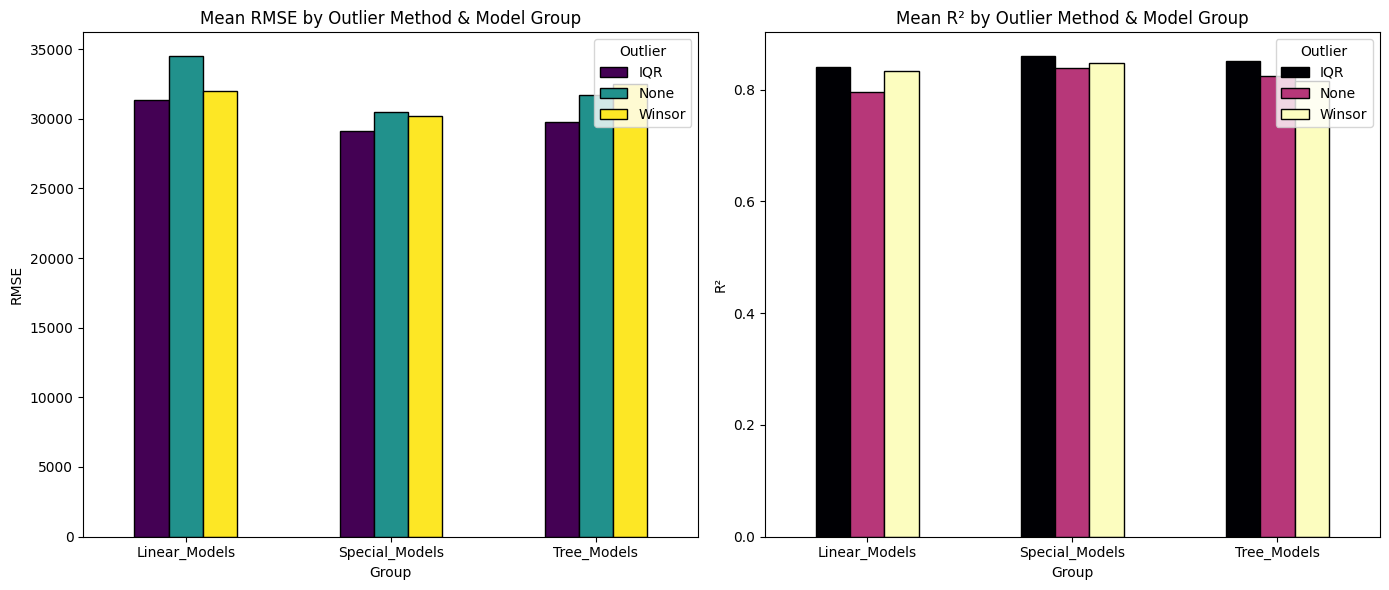

In [ ]:
# Pivot để vẽ
pivot_rmse = all_outlier_results.pivot_table(
    index="Group", columns="Outlier_Experiment", values="Mean_RMSE", aggfunc="mean"
)
pivot_r2 = all_outlier_results.pivot_table(
    index="Group", columns="Outlier_Experiment", values="Mean_R2", aggfunc="mean"
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# RMSE
pivot_rmse.plot(kind="bar", ax=ax1, cmap="viridis", edgecolor="black")
ax1.set_title("Mean RMSE by Outlier Method & Model Group")
ax1.set_ylabel("RMSE")
ax1.legend(title="Outlier")
ax1.tick_params(axis='x', rotation=0)

# R²
pivot_r2.plot(kind="bar", ax=ax2, cmap="magma", edgecolor="black")
ax2.set_title("Mean R² by Outlier Method & Model Group")
ax2.set_ylabel("R²")
ax2.legend(title="Outlier")
ax2.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

## Results

**NOTE**:

- IQR Method giúp tăng score mỗi group ít nhất 10% (~ 0.10 điểm score)

In [20]:
config['outlier_method']  = {}

for name in model_groups.keys():
    config['outlier_method'][name] = "iqr"

# Kiểm tra
import pprint
pprint.pp(config['outlier_method'])

{'Linear_Models': 'iqr', 'Tree_Models': 'iqr', 'Special_Models': 'iqr'}


# Imputer

## Run Experiments

In [21]:
imputer_tests = [
    ("Mean", "simple"),
    ("Median", "simple_median"),
    ("KNN", "knn"),
    ("Iterative", "iterative")
]
config["imputer_type"] = {}

In [22]:
results_imputer = []

for exp_name, imp_val in imputer_tests:
    print(f"\n{'='*80}")
    print(f"  THỬ NGHIỆM IMPUTER: {exp_name}")
    print(f"{'='*80}")

    for group in model_groups.keys():
        config["imputer_type"][group] = imp_val

    for group in model_groups.keys():
        res = evaluate_dataset(
            df=data,
            dataset_name="FS_data",
            base_models=base_models,
            model_groups=model_groups,
            group_name=group,
            config=config,
            n_splits=5
        )
        res["Imputer_Experiment"] = exp_name
        results_imputer.append(res)

all_imputer_results = pd.concat(results_imputer, ignore_index=True)


  THỬ NGHIỆM IMPUTER: Mean

GROUP: Linear_Models | DATASET: FS_data

Model: Ridge
   Fold 1 → RMSE=34093.37, R²=0.8485, Time=0.02s
   Fold 2 → RMSE=30453.81, R²=0.8636, Time=0.02s
   Fold 3 → RMSE=37304.41, R²=0.7481, Time=0.02s
   Fold 4 → RMSE=30388.39, R²=0.8529, Time=0.02s
   Fold 5 → RMSE=24456.06, R²=0.8856, Time=0.02s

Model: Lasso
   Fold 1 → RMSE=32918.92, R²=0.8587, Time=0.08s
   Fold 2 → RMSE=28955.42, R²=0.8767, Time=0.07s
   Fold 3 → RMSE=39594.94, R²=0.7162, Time=0.07s
   Fold 4 → RMSE=30474.59, R²=0.8521, Time=0.07s
   Fold 5 → RMSE=24881.87, R²=0.8816, Time=0.07s

Model: ElasticNet
   Fold 1 → RMSE=35053.95, R²=0.8398, Time=0.08s
   Fold 2 → RMSE=31891.28, R²=0.8504, Time=0.07s
   Fold 3 → RMSE=35862.48, R²=0.7672, Time=0.08s
   Fold 4 → RMSE=30678.29, R²=0.8501, Time=0.05s
   Fold 5 → RMSE=24589.34, R²=0.8843, Time=0.08s

Model: Huber
   Fold 1 → RMSE=34581.94, R²=0.8441, Time=0.08s
   Fold 2 → RMSE=32587.81, R²=0.8438, Time=0.08s
   Fold 3 → RMSE=34564.74, R²=0.7837,

## Best choice

In [23]:
baseline_imputer = all_imputer_results[all_imputer_results["Imputer_Experiment"] == "Mean"]
test_imputer = [
    all_imputer_results[all_imputer_results["Imputer_Experiment"] == "Median"],
    all_imputer_results[all_imputer_results["Imputer_Experiment"] == "KNN"],
    all_imputer_results[all_imputer_results["Imputer_Experiment"] == "Iterative"]
]

imputer_summary = compare_experiment_results(
    base_df=baseline_imputer,
    test_dfs=test_imputer,
    test_names=["Median", "KNN", "Iterative"],
    weights=(0.5, 0.2, 0.3)
)


BẮT ĐẦU SO SÁNH HIỆU NĂNG

NHÓM: Linear_Models
  Median: Score=0.0001, RMSE improve=0.0% (5 models)
  KNN: Score=-0.0019, RMSE improve=-0.1% (5 models)
  Iterative: Score=-0.0022, RMSE improve=-0.1% (5 models)
  BEST: Median (Score: 0.0001)

NHÓM: Special_Models
  Median: Score=-0.0077, RMSE improve=-0.3% (2 models)
  KNN: Score=-0.0135, RMSE improve=0.1% (2 models)
  Iterative: Score=-0.0085, RMSE improve=-0.4% (2 models)
  BEST: Median (Score: -0.0077)

NHÓM: Tree_Models
  Median: Score=-0.0008, RMSE improve=-0.0% (5 models)
  KNN: Score=0.0148, RMSE improve=0.3% (5 models)
  Iterative: Score=0.0114, RMSE improve=0.3% (5 models)
  BEST: KNN (Score: 0.0148)

TỔNG HỢP:
         Group Experiment  Mean_Score  Mean_Improve_RMSE
 Linear_Models     Median    0.000059           0.000011
Special_Models     Median   -0.007666          -0.002695
   Tree_Models        KNN    0.014814           0.002672


In [ ]:
save_df(all_imputer_results, "imputer_results.xlsx", "results/experiments_results")

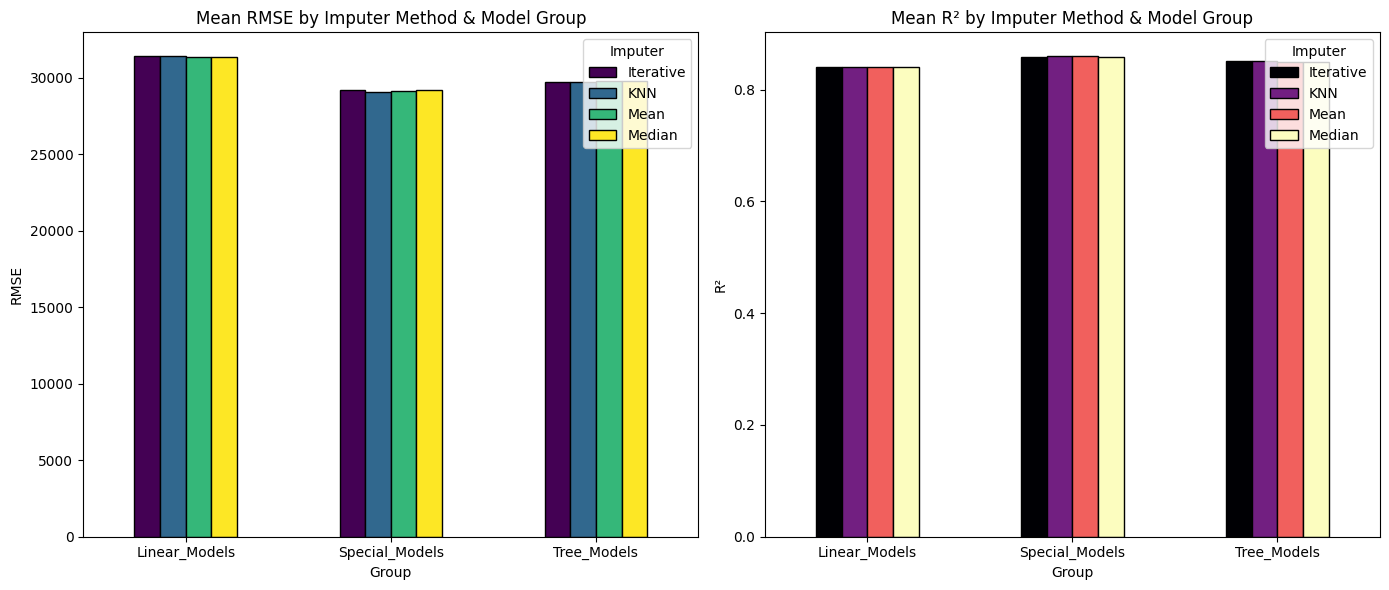

In [25]:
# Pivot để vẽ
pivot_rmse = all_imputer_results.pivot_table(
    index="Group", columns="Imputer_Experiment", values="Mean_RMSE", aggfunc="mean"
)
pivot_r2 = all_imputer_results.pivot_table(
    index="Group", columns="Imputer_Experiment", values="Mean_R2", aggfunc="mean"
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# RMSE
pivot_rmse.plot(kind="bar", ax=ax1, cmap="viridis", edgecolor="black")
ax1.set_title("Mean RMSE by Imputer Method & Model Group")
ax1.set_ylabel("RMSE")
ax1.legend(title="Imputer")
ax1.tick_params(axis='x', rotation=0)

# R²
pivot_r2.plot(kind="bar", ax=ax2, cmap="magma", edgecolor="black")
ax2.set_title("Mean R² by Imputer Method & Model Group")
ax2.set_ylabel("R²")
ax2.legend(title="Imputer")
ax2.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.savefig("imputer_results.png")
plt.show()

## Results

**NOTE**:

- Không có sự khác biệt đáng kể giữa mean và median ở group Linear Model

- Vì vậy, cả 2 group Linear và Special sẽ sử dụng mean (baseline)

- Sử dụng KNN cho group Tree

In [26]:
for name in model_groups.keys():
    config['imputer_type'][name] = "simple" if name != "Tree_Models" else "knn"

# Kiểm tra
import pprint
pprint.pp(config['imputer_type'])

{'Linear_Models': 'simple', 'Tree_Models': 'knn', 'Special_Models': 'simple'}


## Find best k for KNN

In [27]:
# Danh sách k cần thử
k_values = [3, 5, 7, 9, 11]
results_knn = []

print(f"\n{'='*80}")
print(f"  TÌM K TỐT NHẤT CHO KNN IMPUTER - TREE_MODELS")
print(f"{'='*80}")

for k in k_values:
    print(f"\n→ Thử k = {k}")

    res = evaluate_dataset(
        df=data,
        dataset_name="FS_data",
        base_models=base_models,
        model_groups=model_groups,
        group_name="Tree_Models",
        config=config,
        n_splits=5,
        knn_neighbors=k
    )
    res["K_Value"] = k
    res["Experiment"] = f"KNN_k={k}"
    results_knn.append(res)

# Gộp kết quả
knn_results = pd.concat(results_knn, ignore_index=True)


  TÌM K TỐT NHẤT CHO KNN IMPUTER - TREE_MODELS

→ Thử k = 3

GROUP: Tree_Models | DATASET: FS_data

Model: RF
   Fold 1 → RMSE=29158.69, R²=0.8892, Time=1.28s
   Fold 2 → RMSE=25592.12, R²=0.9037, Time=1.23s
   Fold 3 → RMSE=37914.79, R²=0.7398, Time=1.34s
   Fold 4 → RMSE=28713.01, R²=0.8687, Time=1.33s
   Fold 5 → RMSE=23732.75, R²=0.8922, Time=1.24s

Model: XGB
   Fold 1 → RMSE=25656.49, R²=0.9142, Time=0.15s
   Fold 2 → RMSE=25732.57, R²=0.9026, Time=0.17s
   Fold 3 → RMSE=32393.33, R²=0.8101, Time=0.18s
   Fold 4 → RMSE=31433.02, R²=0.8426, Time=0.17s
   Fold 5 → RMSE=24659.93, R²=0.8837, Time=0.18s

Model: GB
   Fold 1 → RMSE=27246.77, R²=0.9032, Time=0.51s
   Fold 2 → RMSE=22816.88, R²=0.9234, Time=0.39s
   Fold 3 → RMSE=37499.58, R²=0.7455, Time=0.40s
   Fold 4 → RMSE=27830.15, R²=0.8767, Time=0.40s
   Fold 5 → RMSE=21676.51, R²=0.9101, Time=0.41s

Model: LGBM
   Fold 1 → RMSE=29571.43, R²=0.8860, Time=0.11s
   Fold 2 → RMSE=27406.85, R²=0.8895, Time=0.12s
   Fold 3 → RMSE=373

In [28]:
# Tính RMSE trung bình theo k
summary_k = knn_results.groupby("K_Value").agg(
    Mean_RMSE=("Mean_RMSE", "mean"),
    Std_RMSE=("Mean_RMSE", "std"),
    Mean_R2=("Mean_R2", "mean")
).round(4)

print("\n" + "="*60)
print("KẾT QUẢ THEO K (Tree_Models)")
print("="*60)
print(summary_k)

# Tìm k tốt nhất
best_k = summary_k["Mean_RMSE"].idxmin()
best_rmse = summary_k.loc[best_k, "Mean_RMSE"]

print(f"\n→ K TỐT NHẤT: k = {best_k} (RMSE = {best_rmse:.4f})")


KẾT QUẢ THEO K (Tree_Models)
          Mean_RMSE   Std_RMSE  Mean_R2
K_Value                                
3        29721.9063  3090.6011   0.8514
5        29684.6239  3071.9727   0.8518
7        29787.5188  3259.3866   0.8505
9        29550.8615  3412.9249   0.8529
11       29771.6610  3145.3488   0.8506

→ K TỐT NHẤT: k = 9 (RMSE = 29550.8615)


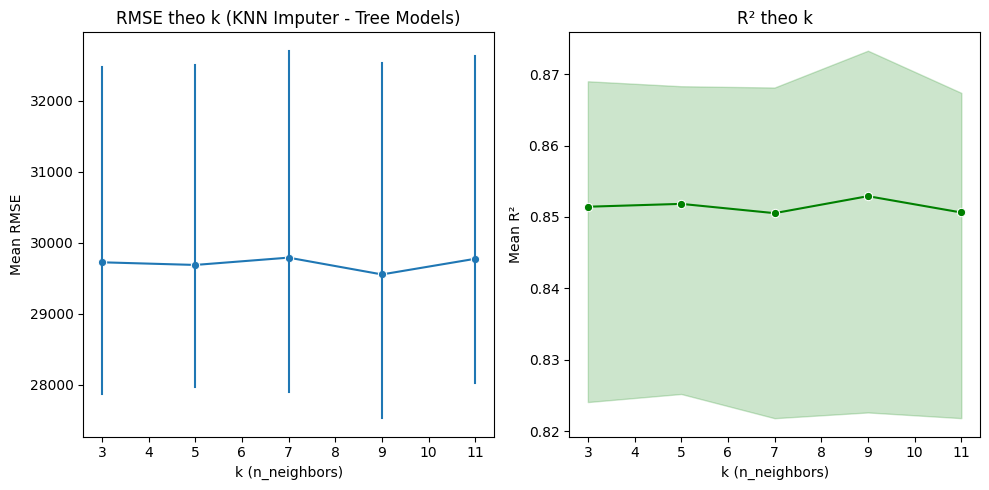

In [29]:
plt.figure(figsize=(10, 5))

# RMSE theo k
plt.subplot(1, 2, 1)
sns.lineplot(data=knn_results, x="K_Value", y="Mean_RMSE", marker="o", err_style="bars")
plt.title("RMSE theo k (KNN Imputer - Tree Models)")
plt.ylabel("Mean RMSE")
plt.xlabel("k (n_neighbors)")

# R² theo k
plt.subplot(1, 2, 2)
sns.lineplot(data=knn_results, x="K_Value", y="Mean_R2", marker="o", color="green")
plt.title("R² theo k")
plt.ylabel("Mean R²")
plt.xlabel("k (n_neighbors)")

plt.tight_layout()
plt.savefig("knn_find_best_k.png")
plt.show()

In [30]:
config["knn_neighbors"] = {
    'Tree_Models': int(best_k),
    'Linear_Models': 5,
    'Special_Models': 5
}

# Transformation

## Run Experiments

In [ ]:
input_tf_tests = [
    ("None", "org"),
    ("Log", "log"),
    ("Sqrt", "sqrt"),
    ("Yeo", "yeo-johnson")
]

target_tf_tests = [
    ("None", "org"),
    ("Log", "log"),
    ("Sqrt", "sqrt"),
    ("Yeo", "yeo-johnson"),
    ("BoxCox", "box-cox")
]

pair_tests = []
for in_name, in_tf in input_tf_tests:
  for tg_name, tg_tf in target_tf_tests:
    pair_tests.append((in_tf, tg_tf, f"{in_name}_{tg_name}"))

config["input_transform"]= {}
config["target_transform"] = {}
pair_tests

[('org', 'org', 'None_None'),
 ('org', 'log', 'None_Log'),
 ('org', 'sqrt', 'None_Sqrt'),
 ('org', 'yeo-johnson', 'None_Yeo'),
 ('org', 'box-cox', 'None_BoxCox'),
 ('log', 'org', 'Log_None'),
 ('log', 'log', 'Log_Log'),
 ('log', 'sqrt', 'Log_Sqrt'),
 ('log', 'yeo-johnson', 'Log_Yeo'),
 ('log', 'box-cox', 'Log_BoxCox'),
 ('sqrt', 'org', 'Sqrt_None'),
 ('sqrt', 'log', 'Sqrt_Log'),
 ('sqrt', 'sqrt', 'Sqrt_Sqrt'),
 ('sqrt', 'yeo-johnson', 'Sqrt_Yeo'),
 ('sqrt', 'box-cox', 'Sqrt_BoxCox'),
 ('yeo-johnson', 'org', 'Yeo_None'),
 ('yeo-johnson', 'log', 'Yeo_Log'),
 ('yeo-johnson', 'sqrt', 'Yeo_Sqrt'),
 ('yeo-johnson', 'yeo-johnson', 'Yeo_Yeo'),
 ('yeo-johnson', 'box-cox', 'Yeo_BoxCox')]

In [ ]:
results_transform = []

print(f"\n{'='*90}")
print(f"  THỬ NGHIỆM CẶP (INPUT + TARGET) TRANSFORM + BOX-COX")
print(f"{'='*90}")

for in_tf, tgt_tf, exp_name in pair_tests:
    print(f"\n→ CẶP: {exp_name}")

    # Override config
    for group in model_groups.keys():
        config["input_transform"][group] = in_tf
        config["target_transform"][group] = tgt_tf

    for group in model_groups.keys():
        print(f"   Running {group}...")
        try:
            res = evaluate_dataset(
                df=data,
                dataset_name="FS_data",
                base_models=base_models,
                model_groups=model_groups,
                group_name=group,
                config=config,
                n_splits=5,
                knn_neighbors=config["knn_neighbors"].get(group, 5)
            )
            res["Transform_Experiment"] = exp_name
            res["Input_Transform"] = in_tf
            res["Target_Transform"] = tgt_tf
            results_transform.append(res)
        except Exception as e:
            print(f"   [LỖI] {group} - {exp_name}: {e}")

all_transform_results = pd.concat(results_transform, ignore_index=True)


  THỬ NGHIỆM CẶP (INPUT + TARGET) TRANSFORM + BOX-COX

→ CẶP: None_None
   Running Linear_Models...

GROUP: Linear_Models | DATASET: FS_data

Model: Ridge
   Fold 1 → RMSE=34093.37, R²=0.8485, Time=0.06s
   Fold 2 → RMSE=30453.81, R²=0.8636, Time=0.13s
   Fold 3 → RMSE=37304.41, R²=0.7481, Time=0.14s
   Fold 4 → RMSE=30388.39, R²=0.8529, Time=0.07s
   Fold 5 → RMSE=24456.06, R²=0.8856, Time=0.11s

Model: Lasso
   Fold 1 → RMSE=32918.92, R²=0.8587, Time=0.25s
   Fold 2 → RMSE=28955.42, R²=0.8767, Time=0.24s
   Fold 3 → RMSE=39594.94, R²=0.7162, Time=0.23s
   Fold 4 → RMSE=30474.59, R²=0.8521, Time=0.22s
   Fold 5 → RMSE=24881.87, R²=0.8816, Time=0.25s

Model: ElasticNet
   Fold 1 → RMSE=35053.95, R²=0.8398, Time=0.24s
   Fold 2 → RMSE=31891.28, R²=0.8504, Time=0.22s
   Fold 3 → RMSE=35862.48, R²=0.7672, Time=0.25s
   Fold 4 → RMSE=30678.29, R²=0.8501, Time=0.23s
   Fold 5 → RMSE=24589.34, R²=0.8843, Time=0.23s

Model: Huber
   Fold 1 → RMSE=34581.94, R²=0.8441, Time=0.40s
   Fold 2 → R

## Best choice

In [ ]:
transform_baseline = all_transform_results[all_transform_results["Transform_Experiment"] == "None_None"]
transform_test_name = [name for _, _, name in pair_tests if name != "None_None"]
transform_test_dfs = [all_transform_results[all_transform_results["Transform_Experiment"] == name] for name in transform_test_name]

summary = compare_experiment_results(
    base_df=transform_baseline,
    test_dfs=transform_test_dfs,
    test_names=transform_test_name,
    weights=(0.55, 0.15, 0.3)
)


BẮT ĐẦU SO SÁNH HIỆU NĂNG

NHÓM: Linear_Models
  None_Log: Score=-0.2386, RMSE improve=-23.4% (5 models)
  None_Sqrt: Score=0.0365, RMSE improve=7.5% (5 models)
  None_Yeo: Score=-0.3296, RMSE improve=-30.8% (5 models)
  None_BoxCox: Score=-0.3283, RMSE improve=-30.7% (5 models)
  Log_None: Score=-0.0677, RMSE improve=-13.3% (5 models)
  Log_Log: Score=-0.7753, RMSE improve=-51.2% (5 models)
  Log_Sqrt: Score=-0.0103, RMSE improve=-4.8% (5 models)
  Log_Yeo: Score=-3.8674, RMSE improve=-127.1% (5 models)
  Log_BoxCox: Score=-4.0202, RMSE improve=-130.4% (5 models)
  Sqrt_None: Score=-0.0359, RMSE improve=-7.3% (5 models)
  Sqrt_Log: Score=-0.2220, RMSE improve=-27.2% (5 models)
  Sqrt_Sqrt: Score=0.0161, RMSE improve=1.0% (5 models)
  Sqrt_Yeo: Score=-0.2955, RMSE improve=-34.6% (5 models)
  Sqrt_BoxCox: Score=-0.2978, RMSE improve=-34.8% (5 models)
  Yeo_None: Score=-0.0396, RMSE improve=-8.3% (5 models)
  Yeo_Log: Score=-0.2013, RMSE improve=-26.7% (5 models)
  Yeo_Sqrt: Score=0.026

In [ ]:
save_df(all_transform_results, "transform_results.xlsx", "results/experiments_results/")

## Results

In [ ]:
config["input_transform"] = {}
for name in model_groups.keys():
    config['input_transform'][name] = "org" if name != "Tree_Models" else "log"

config["target_transform"] = {}
config["target_transform"]["Linear_Models"]  = "sqrt"
config["target_transform"]["Tree_Models"]  = "org"
config["target_transform"]["Special_Models"]  = "log"

# Kiểm tra
import pprint
pprint.pp(config['input_transform'])
pprint.pp(config['target_transform'])

{'Linear_Models': 'org', 'Tree_Models': 'log', 'Special_Models': 'org'}
{'Linear_Models': 'sqrt', 'Tree_Models': 'org', 'Special_Models': 'log'}


In [ ]:
config

{'outlier_method': {'Linear_Models': 'iqr',
  'Tree_Models': 'iqr',
  'Special_Models': 'iqr'},
 'imputer_type': {'Linear_Models': 'simple',
  'Tree_Models': 'knn',
  'Special_Models': 'simple'},
 'knn_neighbors': {'Tree_Models': 9, 'Linear_Models': 5, 'Special_Models': 5},
 'input_transform': {'Linear_Models': 'org',
  'Tree_Models': 'log',
  'Special_Models': 'org'},
 'target_transform': {'Linear_Models': 'sqrt',
  'Tree_Models': 'org',
  'Special_Models': 'log'}}

# Scaler

## Run Experiments

In [ ]:
scaler_tests = [
    ("MinMax", "minmax"),
    ("Standard", "standard"),
    ("Robust", "robust")
]
config["scaler_type"] = {}

In [ ]:
results_scaler = []

for scaler_name, scaler_type in scaler_tests:
    print(f"\n{'='*80}")
    print(f"  THỬ NGHIỆM SCALER = {scaler_name}")
    print(f"{'='*80}")

    # Override config cho tất cả nhóm
    for group in model_groups.keys():
        config["scaler_type"][group] = scaler_type

    for group in model_groups.keys():
        print(f"   Running {group}...")
        res = evaluate_dataset(
            df=data,
            dataset_name="FS_data",
            base_models=base_models,
            model_groups=model_groups,
            group_name=group,
            config=config,
            n_splits=5,
            knn_neighbors=config["knn_neighbors"].get(group, 5)
        )
        res["Scaler_Experiment"] = scaler_name
        results_scaler.append(res)

# Gộp
all_scaler_results = pd.concat(results_scaler, ignore_index=True)


  THỬ NGHIỆM SCALER = MinMax
   Running Linear_Models...

GROUP: Linear_Models | DATASET: FS_data

Model: Ridge
   Fold 1 → RMSE=30296.14, R²=0.8803, Time=0.05s
   Fold 2 → RMSE=27357.20, R²=0.8899, Time=0.06s
   Fold 3 → RMSE=36040.58, R²=0.7649, Time=0.06s
   Fold 4 → RMSE=28226.57, R²=0.8731, Time=0.07s
   Fold 5 → RMSE=20990.04, R²=0.9157, Time=0.06s

Model: Lasso
   Fold 1 → RMSE=34529.47, R²=0.8446, Time=0.06s
   Fold 2 → RMSE=31972.61, R²=0.8497, Time=0.05s
   Fold 3 → RMSE=34006.10, R²=0.7907, Time=0.05s
   Fold 4 → RMSE=31042.48, R²=0.8465, Time=0.04s
   Fold 5 → RMSE=23763.10, R²=0.8920, Time=0.05s

Model: ElasticNet
   Fold 1 → RMSE=31156.09, R²=0.8734, Time=0.10s
   Fold 2 → RMSE=28912.18, R²=0.8771, Time=0.09s
   Fold 3 → RMSE=34311.89, R²=0.7869, Time=0.09s
   Fold 4 → RMSE=28785.03, R²=0.8680, Time=0.11s
   Fold 5 → RMSE=21385.31, R²=0.9125, Time=0.10s

Model: Huber
   Fold 1 → RMSE=30066.55, R²=0.8821, Time=0.12s
   Fold 2 → RMSE=27498.18, R²=0.8888, Time=0.13s
   Fold

## Best choice

In [ ]:
baseline_scaler = all_scaler_results[all_scaler_results["Scaler_Experiment"] == "MinMax"]

# Test: Standard, Robust
test_scaler_dfs = [
    all_scaler_results[all_scaler_results["Scaler_Experiment"] == "Standard"],
    all_scaler_results[all_scaler_results["Scaler_Experiment"] == "Robust"]
]

summary = compare_experiment_results(
    base_df=baseline_scaler,
    test_dfs=test_scaler_dfs,
    test_names=["Standard", "Robust"],
    weights=(0.5, 0.2, 0.3)
)


BẮT ĐẦU SO SÁNH HIỆU NĂNG

NHÓM: Linear_Models
  Standard: Score=-0.0258, RMSE improve=1.9% (5 models)
  Robust: Score=-0.0151, RMSE improve=1.9% (5 models)
  BEST: Robust (Score: -0.0151)

NHÓM: Special_Models
  Standard: Score=-0.0215, RMSE improve=0.2% (2 models)
  Robust: Score=-0.0192, RMSE improve=0.1% (2 models)
  BEST: Robust (Score: -0.0192)

NHÓM: Tree_Models
  Standard: Score=-0.0007, RMSE improve=-0.1% (5 models)
  Robust: Score=-0.0008, RMSE improve=-0.1% (5 models)
  BEST: Standard (Score: -0.0007)

TỔNG HỢP:
         Group Experiment  Mean_Score  Mean_Improve_RMSE
 Linear_Models     Robust   -0.015113           0.019015
Special_Models     Robust   -0.019161           0.001434
   Tree_Models   Standard   -0.000744          -0.000644


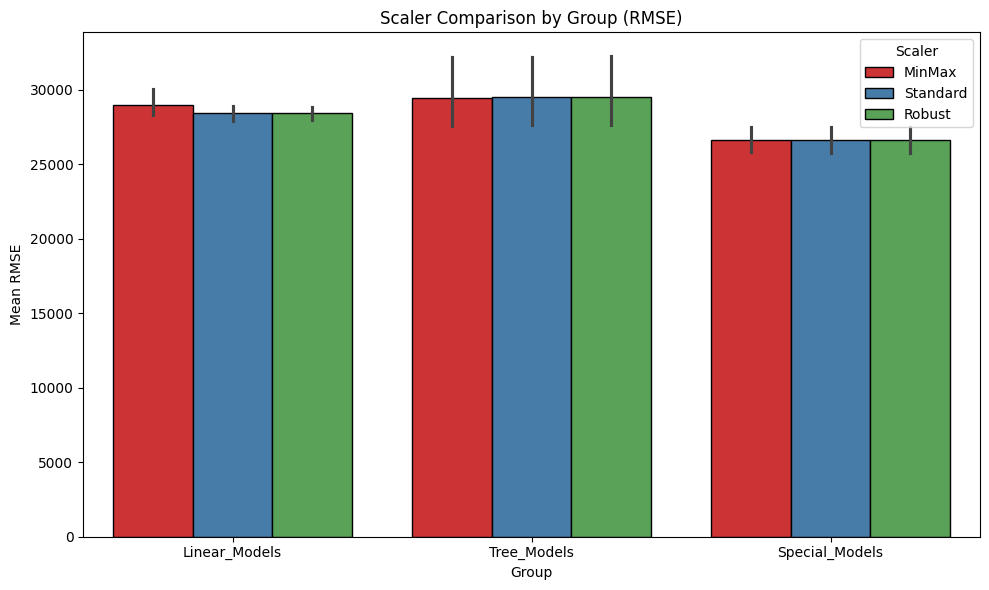

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=all_scaler_results,
    x="Group", y="Mean_RMSE", hue="Scaler_Experiment",
    palette="Set1", edgecolor="black"
)
plt.title("Scaler Comparison by Group (RMSE)")
plt.ylabel("Mean RMSE")
plt.legend(title="Scaler")
plt.tight_layout()
plt.savefig("scaler_results.png")
plt.show()

In [ ]:
save_df(all_scaler_results, "scaler_results.xlsx", "results/experiments_results")

## Results

**NOTE**:

- Cả 3 group đều có score < 0
- Với Linear Models, Standard và Robust Scaler giúp giảm RMSE nhưng lại làm tăng nhiều std RMSE -> chọn MinMaxScaler (baseline)

In [ ]:
config['scaler_type']  = {}

for name in model_groups.keys():
    config['scaler_type'][name] = "minmax"

# Kiểm tra
import pprint
pprint.pp(config['scaler_type'])

{'Linear_Models': 'minmax', 'Tree_Models': 'minmax', 'Special_Models': 'minmax'}


# Encoder

**Option:**

- OneHotEncoder

- TargetEncoder

## Run Experiments

In [ ]:
encoder_configs = [
    ("OneHot", "onehot"),
    ("Target", "target")
]
config["encoder_type"] = {}

In [ ]:
results_encoder = []

for enc_name, enc_type in encoder_configs:
    print(f"\n{'='*80}")
    print(f"  THỬ NGHIỆM ENCODER = {enc_name}")
    print(f"{'='*80}")

    # Override config cho tất cả nhóm
    for group in model_groups.keys():
        config["encoder_type"][group] = enc_type

    for group in model_groups.keys():
        print(f"   Running {group}...")
        res = evaluate_dataset(
            df=data,
            dataset_name="FS_data",
            base_models=base_models,
            model_groups=model_groups,
            group_name=group,
            config=config,
            n_splits=5,
            knn_neighbors=config["knn_neighbors"].get(group, 5)
        )
        res["Encoder_Experiment"] = enc_name
        results_encoder.append(res)

# Gộp
all_encoder_results = pd.concat(results_encoder, ignore_index=True)


  THỬ NGHIỆM ENCODER = OneHot
   Running Linear_Models...

GROUP: Linear_Models | DATASET: FS_data

Model: Ridge
   Fold 1 → RMSE=30296.14, R²=0.8803, Time=0.05s
   Fold 2 → RMSE=27357.20, R²=0.8899, Time=0.07s
   Fold 3 → RMSE=36040.58, R²=0.7649, Time=0.06s
   Fold 4 → RMSE=28226.57, R²=0.8731, Time=0.06s
   Fold 5 → RMSE=20990.04, R²=0.9157, Time=0.06s

Model: Lasso
   Fold 1 → RMSE=34529.47, R²=0.8446, Time=0.06s
   Fold 2 → RMSE=31972.61, R²=0.8497, Time=0.06s
   Fold 3 → RMSE=34006.10, R²=0.7907, Time=0.05s
   Fold 4 → RMSE=31042.48, R²=0.8465, Time=0.05s
   Fold 5 → RMSE=23763.10, R²=0.8920, Time=0.05s

Model: ElasticNet
   Fold 1 → RMSE=31156.09, R²=0.8734, Time=0.08s
   Fold 2 → RMSE=28912.18, R²=0.8771, Time=0.07s
   Fold 3 → RMSE=34311.89, R²=0.7869, Time=0.07s
   Fold 4 → RMSE=28785.03, R²=0.8680, Time=0.08s
   Fold 5 → RMSE=21385.31, R²=0.9125, Time=0.10s

Model: Huber
   Fold 1 → RMSE=30066.55, R²=0.8821, Time=0.20s
   Fold 2 → RMSE=27498.18, R²=0.8888, Time=0.23s
   Fol

## Best choice

In [ ]:
baseline_encoder = all_encoder_results[all_encoder_results["Encoder_Experiment"] == "OneHot"]

summary = compare_experiment_results(
    base_df=baseline_encoder,
    test_dfs=[all_encoder_results[all_encoder_results["Encoder_Experiment"] == "Target"]],
    test_names=["Target"],
    weights=(0.5, 0.2, 0.3)  # RMSE quan trọng nhất
)


BẮT ĐẦU SO SÁNH HIỆU NĂNG

NHÓM: Linear_Models
  Target: Score=0.0126, RMSE improve=-0.5% (5 models)
  BEST: Target (Score: 0.0126)

NHÓM: Special_Models
  Target: Score=0.0269, RMSE improve=0.9% (2 models)
  BEST: Target (Score: 0.0269)

NHÓM: Tree_Models
  Target: Score=0.0209, RMSE improve=2.0% (5 models)
  BEST: Target (Score: 0.0209)

TỔNG HỢP:
         Group Experiment  Mean_Score  Mean_Improve_RMSE
 Linear_Models     Target    0.012598          -0.005362
Special_Models     Target    0.026862           0.009131
   Tree_Models     Target    0.020914           0.020059


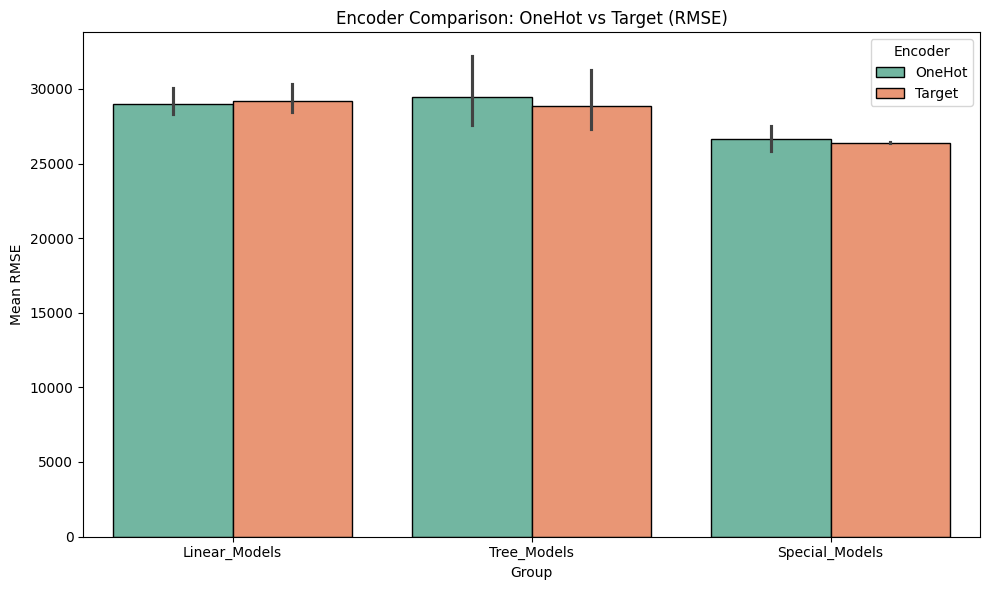

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(
    data=all_encoder_results,
    x="Group", y="Mean_RMSE", hue="Encoder_Experiment",
    palette="Set2", edgecolor="black"
)
plt.title("Encoder Comparison: OneHot vs Target (RMSE)")
plt.ylabel("Mean RMSE")
plt.legend(title="Encoder")
plt.tight_layout()
plt.savefig("encoder_results.png")
plt.show()

In [ ]:
save_df(all_encoder_results, "encoder_results.xlsx", "results/experiments_results")

## Results

In [ ]:
config['encoder_type']  = {}

for name in model_groups.keys():
    config['encoder_type'][name] = "target"

# Kiểm tra
import pprint
pprint.pp(config['encoder_type'])

{'Linear_Models': 'target', 'Tree_Models': 'target', 'Special_Models': 'target'}


## Choose smothing value

In [ ]:
smoothing_values = [1, 5, 10, 20, 50, 100]

In [ ]:
results_smoothing = []

print(f"\n{'='*90}")
print(f"  TÌM SMOOTHING TỐT NHẤT CHO TARGET ENCODER")
print(f"{'='*90}")

for smooth in smoothing_values:
    print(f"\n→ SMOOTHING = {smooth}")

    for group in model_groups.keys():
        print(f"   Running {group}...")
        res = evaluate_dataset(
            df=data,
            dataset_name="FS_data",
            base_models=base_models,
            model_groups=model_groups,
            group_name=group,
            config=config,
            n_splits=5,
            knn_neighbors=config["knn_neighbors"].get(group, 5),
            target_encoder_smoothing=smooth
        )
        res["Smoothing_Value"] = smooth
        res["Experiment"] = f"Smooth_{smooth}"
        results_smoothing.append(res)

# Gộp
all_smoothing_results = pd.concat(results_smoothing, ignore_index=True)


  TÌM SMOOTHING TỐT NHẤT CHO TARGET ENCODER

→ SMOOTHING = 1
   Running Linear_Models...

GROUP: Linear_Models | DATASET: FS_data

Model: Ridge
   Fold 1 → RMSE=29759.65, R²=0.8845, Time=0.14s
   Fold 2 → RMSE=27092.71, R²=0.8920, Time=0.13s
   Fold 3 → RMSE=36140.31, R²=0.7636, Time=0.13s
   Fold 4 → RMSE=28027.36, R²=0.8749, Time=0.14s
   Fold 5 → RMSE=22375.93, R²=0.9042, Time=0.15s

Model: Lasso
   Fold 1 → RMSE=34639.94, R²=0.8436, Time=0.14s
   Fold 2 → RMSE=32183.62, R²=0.8477, Time=0.16s
   Fold 3 → RMSE=33519.51, R²=0.7966, Time=0.19s
   Fold 4 → RMSE=31416.85, R²=0.8428, Time=0.17s
   Fold 5 → RMSE=26372.00, R²=0.8669, Time=0.17s

Model: ElasticNet
   Fold 1 → RMSE=30563.23, R²=0.8782, Time=0.18s
   Fold 2 → RMSE=28491.91, R²=0.8806, Time=0.19s
   Fold 3 → RMSE=34281.11, R²=0.7873, Time=0.17s
   Fold 4 → RMSE=28695.51, R²=0.8689, Time=0.19s
   Fold 5 → RMSE=22895.84, R²=0.8997, Time=0.19s

Model: Huber
   Fold 1 → RMSE=29123.95, R²=0.8894, Time=0.57s
   Fold 2 → RMSE=25206.1

In [ ]:
summary_smooth = (
    all_smoothing_results
    .groupby(["Group", "Smoothing_Value"])["Mean_RMSE"]
    .mean()
    .reset_index()
)

# Tìm smoothing tốt nhất (RMSE thấp nhất)
best_smooth = summary_smooth.loc[summary_smooth.groupby("Group")["Mean_RMSE"].idxmin()]

print("\n" + "="*70)
print("           SMOOTHING TỐT NHẤT CHO TỪNG GROUP")
print("="*70)
for _, row in best_smooth.iterrows():
    print(f"{row['Group']:<15}: smoothing = {int(row['Smoothing_Value']):>3} | RMSE = {row['Mean_RMSE']:.5f}")


           SMOOTHING TỐT NHẤT CHO TỪNG GROUP
Linear_Models  : smoothing = 100 | RMSE = 28948.65120
Special_Models : smoothing = 100 | RMSE = 26342.88382
Tree_Models    : smoothing =  10 | RMSE = 28847.17691


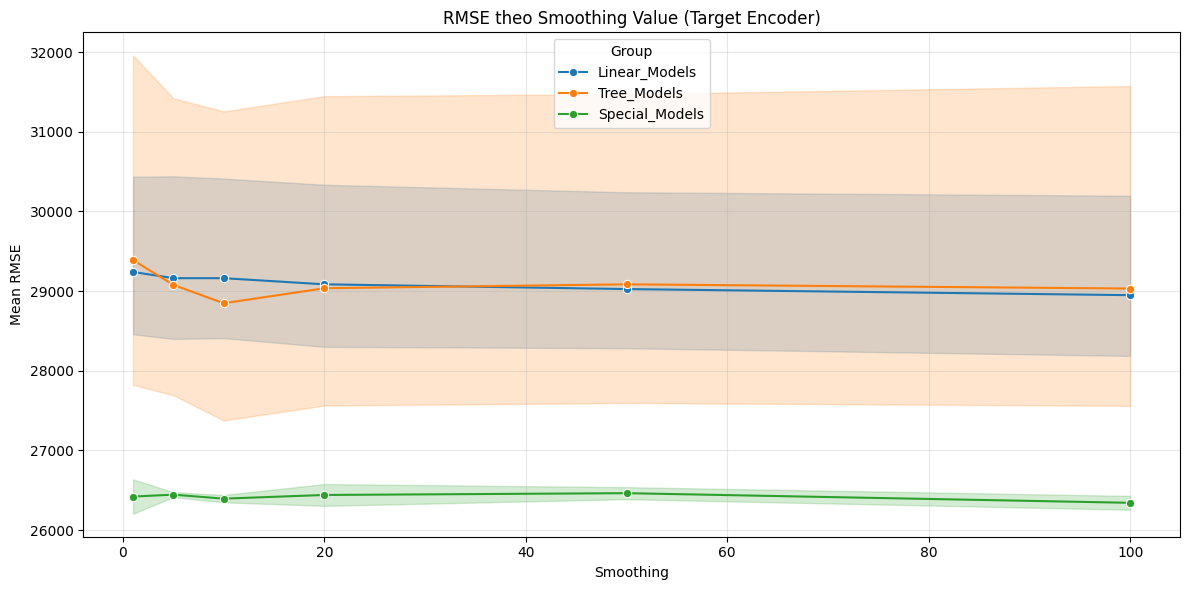

In [ ]:
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=all_smoothing_results,
    x="Smoothing_Value", y="Mean_RMSE", hue="Group",
    marker="o", palette="tab10"
)
plt.title("RMSE theo Smoothing Value (Target Encoder)")
plt.xlabel("Smoothing")
plt.ylabel("Mean RMSE")
plt.legend(title="Group")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("smothing_choice.png")
plt.show()

In [ ]:
smoothing_dict = dict(zip(best_smooth["Group"], best_smooth["Smoothing_Value"].astype(int)))

# Cập nhật config
config["target_encoder_smoothing"] = smoothing_dict

# Polynomial & Feature Interaction

## Run Experiments

In [ ]:
config["poly_features"] = {
    "Linear_Models": False,
    "Tree_Models": False,     # luôn False
    "Special_Models": False   # luôn False
}

In [ ]:
poly_configs = [
    ("No_Poly", False),
    ("With_Poly", True)
]

results_poly = []

print(f"\n{'='*90}")
print(f"  THỬ NGHIỆM POLYNOMIAL FEATURES (degree=2) - CHỈ LINEAR MODELS")
print(f"{'='*90}")

for poly_name, poly_enabled in poly_configs:
    print(f"\n→ {poly_name}")

    # Chỉ override cho Linear_Models
    config["poly_features"]["Linear_Models"] = poly_enabled

    print(f"   Running Linear_Models...")
    res = evaluate_dataset(
        df=data,
        dataset_name="FS_data",
        base_models=base_models,
        model_groups=model_groups,
        group_name="Linear_Models",
        config=config,
        n_splits=5,
        knn_neighbors=config["knn_neighbors"].get("Linear_Models", 5),
        target_encoder_smoothing=config["target_encoder_smoothing"].get("Linear_Models", 10)
    )
    res["Poly_Experiment"] = poly_name
    results_poly.append(res)

# Gộp
all_poly_results = pd.concat(results_poly, ignore_index=True)


  THỬ NGHIỆM POLYNOMIAL FEATURES (degree=2) - CHỈ LINEAR MODELS

→ No_Poly
   Running Linear_Models...

GROUP: Linear_Models | DATASET: FS_data

Model: Ridge
   Fold 1 → RMSE=29709.48, R²=0.8849, Time=0.13s
   Fold 2 → RMSE=26853.84, R²=0.8939, Time=0.15s
   Fold 3 → RMSE=35797.47, R²=0.7680, Time=0.14s
   Fold 4 → RMSE=28116.00, R²=0.8741, Time=0.20s
   Fold 5 → RMSE=21433.43, R²=0.9121, Time=0.26s

Model: Lasso
   Fold 1 → RMSE=34944.59, R²=0.8408, Time=0.16s
   Fold 2 → RMSE=32425.05, R²=0.8454, Time=0.17s
   Fold 3 → RMSE=33187.61, R²=0.8006, Time=0.19s
   Fold 4 → RMSE=31527.49, R²=0.8417, Time=0.17s
   Fold 5 → RMSE=25039.49, R²=0.8800, Time=0.19s

Model: ElasticNet
   Fold 1 → RMSE=30554.77, R²=0.8783, Time=0.18s
   Fold 2 → RMSE=28334.82, R²=0.8819, Time=0.18s
   Fold 3 → RMSE=33953.51, R²=0.7913, Time=0.20s
   Fold 4 → RMSE=28751.04, R²=0.8684, Time=0.19s
   Fold 5 → RMSE=21844.37, R²=0.9087, Time=0.19s

Model: Huber
   Fold 1 → RMSE=28992.46, R²=0.8904, Time=0.47s
   Fold 2 

In [ ]:
save_df(all_poly_results, "poly_results.xlsx", "results/experiments_results")

## Best choice

In [ ]:
# Baseline: No_Poly
baseline_poly = all_poly_results[all_poly_results["Poly_Experiment"] == "No_Poly"]

summary = compare_experiment_results(
    base_df=baseline_poly,
    test_dfs=all_poly_results[all_poly_results["Poly_Experiment"] == "With_Poly"],
    test_names=["With_Poly"],
    weights=(0.7, 0.1, 0.2)
)


BẮT ĐẦU SO SÁNH HIỆU NĂNG

NHÓM: Linear_Models
  With_Poly: Score=-0.0404, RMSE improve=3.1% (5 models)
  BEST: With_Poly (Score: -0.0404)

TỔNG HỢP:
        Group Experiment  Mean_Score  Mean_Improve_RMSE
Linear_Models  With_Poly   -0.040421           0.030664


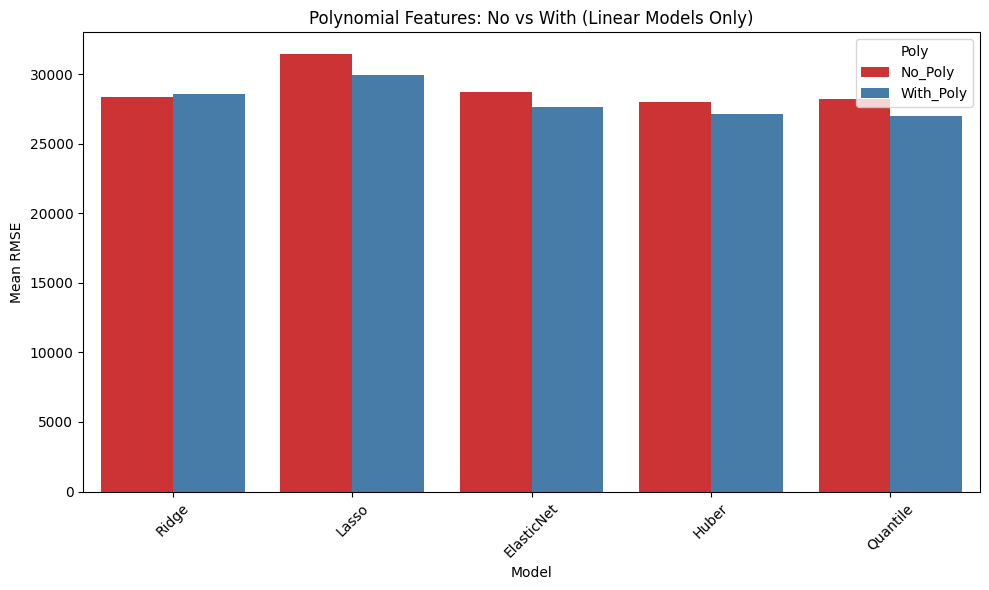

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=all_poly_results,
    x="Model", y="Mean_RMSE", hue="Poly_Experiment",
    palette="Set1"
)
plt.title("Polynomial Features: No vs With (Linear Models Only)")
plt.ylabel("Mean RMSE")
plt.xticks(rotation=45)
plt.legend(title="Poly")
plt.tight_layout()
plt.savefig("poly_results.png")
plt.show()

## Results

**NOTE**:

- Polynomial giúp các mô hình tuyến tính nắm bắt quan hệ phi tuyến tốt hơn nhưng làm tăng rất mạnh std RMSE

In [ ]:
config['poly_features']  = {}

for name in model_groups.keys():
    config['poly_features'][name] = False

# Kiểm tra
import pprint
pprint.pp(config['poly_features'])

{'Linear_Models': False, 'Tree_Models': False, 'Special_Models': False}


# Handling Multicollinearity

## Run Experiments

In [ ]:
config["multicollinearity"] = {
    "Linear_Models": None,     # sẽ thử
    "Tree_Models": None,       # luôn none
    "Special_Models": None     # sẽ thử
}

In [ ]:
multi_tests = [
    ("None", None),
    ("SelectKBest", "selectkbest"),
    ("PCA", "pca"),
    ("LassoCV", "lassocv"),
]

In [ ]:
results_multi = []

print(f"\n{'='*90}")
print(f"  THỬ NGHIỆM MULTICOLLINEARITY HANDLING")
print(f"{'='*90}")

for method_name, method in multi_tests:
    print(f"\n→ METHOD = {method_name}")

    # Chỉ áp dụng cho Linear và Special
    for group in ["Linear_Models", "Special_Models"]:
        config["multicollinearity"][group] = method

    for group in ["Linear_Models", "Special_Models"]:
        print(f"   Running {group}...")
        try:
            res = evaluate_dataset(
                df=data,
                dataset_name="FS_data",
                base_models=base_models,
                model_groups=model_groups,
                group_name=group,
                config=config,  
                n_splits=5,
                knn_neighbors=config["knn_neighbors"].get(group, 5),
                target_encoder_smoothing=config["target_encoder_smoothing"].get(group, 10)
            )
            res["Multi_Experiment"] = method_name
            results_multi.append(res)
        except Exception as e:
            print(f"   [LỖI] {group} - {method_name}: {e}")

# Gộp
all_multi_results = pd.concat(results_multi, ignore_index=True)


  THỬ NGHIỆM MULTICOLLINEARITY HANDLING

→ METHOD = None
   Running Linear_Models...

GROUP: Linear_Models | DATASET: FS_data

Model: Ridge
   Fold 1 → RMSE=29709.48, R²=0.8849, Time=0.14s
   Fold 2 → RMSE=26853.84, R²=0.8939, Time=0.14s
   Fold 3 → RMSE=35797.47, R²=0.7680, Time=0.15s
   Fold 4 → RMSE=28116.00, R²=0.8741, Time=0.23s
   Fold 5 → RMSE=21433.43, R²=0.9121, Time=0.22s

Model: Lasso
   Fold 1 → RMSE=34944.59, R²=0.8408, Time=0.20s
   Fold 2 → RMSE=32425.05, R²=0.8454, Time=0.19s
   Fold 3 → RMSE=33187.61, R²=0.8006, Time=0.22s
   Fold 4 → RMSE=31527.49, R²=0.8417, Time=0.19s
   Fold 5 → RMSE=25039.49, R²=0.8800, Time=0.18s

Model: ElasticNet
   Fold 1 → RMSE=30554.77, R²=0.8783, Time=0.20s
   Fold 2 → RMSE=28334.82, R²=0.8819, Time=0.19s
   Fold 3 → RMSE=33953.51, R²=0.7913, Time=0.18s
   Fold 4 → RMSE=28751.04, R²=0.8684, Time=0.19s
   Fold 5 → RMSE=21844.37, R²=0.9087, Time=0.20s

Model: Huber
   Fold 1 → RMSE=28992.46, R²=0.8904, Time=0.18s
   Fold 2 → RMSE=25146.95, R

## Best choice

In [ ]:
baseline_multi = all_multi_results[all_multi_results["Multi_Experiment"] == "None"]
test_multi_dfs = [
    all_multi_results[all_multi_results["Multi_Experiment"] == "SelectKBest"],
    all_multi_results[all_multi_results["Multi_Experiment"] == "PCA"],
    all_multi_results[all_multi_results["Multi_Experiment"] == "LassoCV"]
]

summary = compare_experiment_results(
    base_df=baseline_multi,
    test_dfs=test_multi_dfs,
    test_names=["SelectKBest", "PCA", "LassoCV"],
    weights=(0.5, 0.2, 0.3)
)


BẮT ĐẦU SO SÁNH HIỆU NĂNG

NHÓM: Linear_Models
  SelectKBest: Score=-0.0251, RMSE improve=-12.5% (5 models)
  PCA: Score=-0.0920, RMSE improve=-20.1% (5 models)
  LassoCV: Score=0.0008, RMSE improve=0.7% (5 models)
  BEST: LassoCV (Score: 0.0008)

NHÓM: Special_Models
  SelectKBest: Score=-0.0196, RMSE improve=-11.8% (2 models)
  PCA: Score=-0.0453, RMSE improve=-25.9% (2 models)
  LassoCV: Score=-0.0356, RMSE improve=-0.9% (2 models)
  BEST: SelectKBest (Score: -0.0196)

TỔNG HỢP:
         Group  Experiment  Mean_Score  Mean_Improve_RMSE
 Linear_Models     LassoCV    0.000791           0.006678
Special_Models SelectKBest   -0.019637          -0.118068


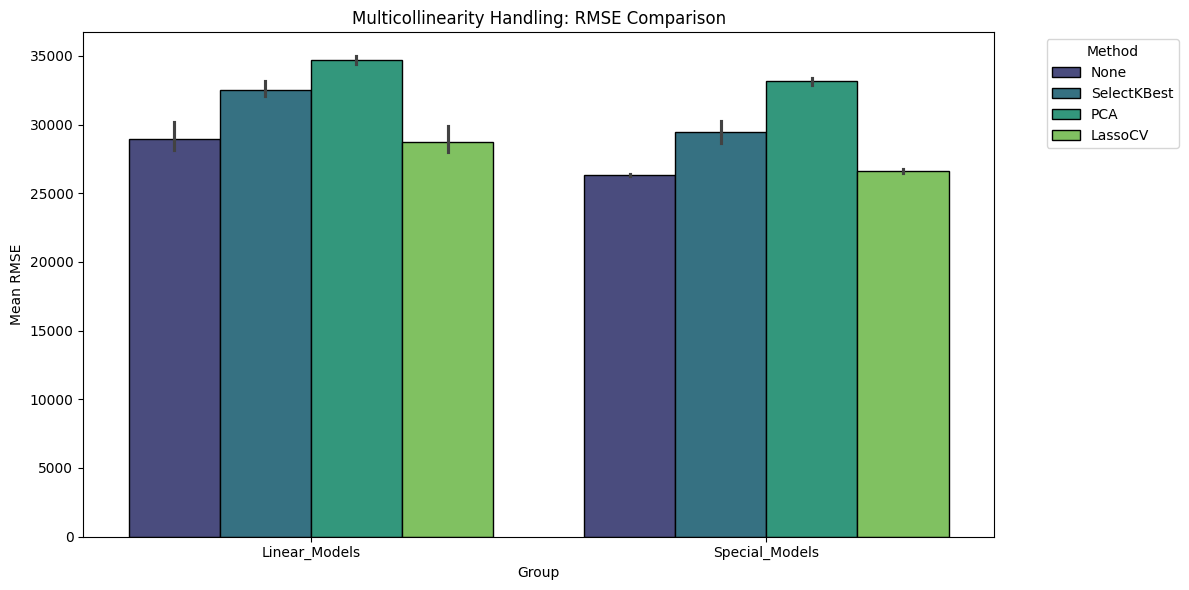

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(
    data=all_multi_results,
    x="Group", y="Mean_RMSE", hue="Multi_Experiment",
    palette="viridis", edgecolor="black"
)
plt.title("Multicollinearity Handling: RMSE Comparison")
plt.ylabel("Mean RMSE")
plt.legend(title="Method", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("multicol_results.png")
plt.show()

In [ ]:
save_df(all_multi_results, "multicol_results.xlsx", "results/experiments_results/")

## Results

**NOTE**:

- LassoCV không có sự ảnh hưởng đáng kể đến Linear Model -> chọn None cho cả 2 group

In [ ]:
config["multicollinearity"] = {
    "Linear_Models": None,
    "Tree_Models": None,
    "Special_Models": None
}

In [24]:
save_json(config, "optimal_config.json", "../data")

Saved: ..\data\optimal_config.json


WindowsPath('../data/optimal_config.json')

# Final results after preprocessing

## FS Data

In [ ]:
FS_results_final = []

print(f"\n{'='*100}")
print(f"  FINAL EVALUATION VỚI CONFIG TỐI ƯU")
print(f"{'='*100}")

for group in model_groups.keys():
    print(f"\n→ Running {group}...")
    res = evaluate_dataset(
        df=data,
        dataset_name="FS_data",
        base_models=base_models,
        model_groups=model_groups,
        group_name=group,
        config=None,
        n_splits=5,
        knn_neighbors=config["knn_neighbors"].get(group, 5),
        target_encoder_smoothing=config["target_encoder_smoothing"].get(group, 10)
    )
    res["Experiment"] = "Final"
    FS_results_final.append(res)

# Gộp kết quả
final_results = pd.concat(FS_results_final, ignore_index=True)


  FINAL EVALUATION VỚI CONFIG TỐI ƯU

→ Running Linear_Models...

GROUP: Linear_Models | DATASET: FS_data

Model: Ridge
   Fold 1 → RMSE=29709.48, R²=0.8849, Time=0.40s
   Fold 2 → RMSE=26853.84, R²=0.8939, Time=0.42s
   Fold 3 → RMSE=35797.47, R²=0.7680, Time=0.29s
   Fold 4 → RMSE=28116.00, R²=0.8741, Time=0.29s
   Fold 5 → RMSE=21433.43, R²=0.9121, Time=0.43s

Model: Lasso
   Fold 1 → RMSE=34944.59, R²=0.8408, Time=0.25s
   Fold 2 → RMSE=32425.05, R²=0.8454, Time=0.59s
   Fold 3 → RMSE=33187.61, R²=0.8006, Time=0.50s
   Fold 4 → RMSE=31527.49, R²=0.8417, Time=0.54s
   Fold 5 → RMSE=25039.49, R²=0.8800, Time=0.56s

Model: ElasticNet
   Fold 1 → RMSE=30554.77, R²=0.8783, Time=0.20s
   Fold 2 → RMSE=28334.82, R²=0.8819, Time=0.22s
   Fold 3 → RMSE=33953.51, R²=0.7913, Time=0.25s
   Fold 4 → RMSE=28751.04, R²=0.8684, Time=0.21s
   Fold 5 → RMSE=21844.37, R²=0.9087, Time=0.35s

Model: Huber
   Fold 1 → RMSE=28992.46, R²=0.8904, Time=0.91s
   Fold 2 → RMSE=25146.95, R²=0.9070, Time=0.84s

In [ ]:
# Tổng hợp RMSE, R² theo nhóm và model
summary_final = final_results.groupby(["Group", "Model"]).agg({
    "Mean_RMSE": ["mean", "std"],
    "Mean_R2": ["mean", "std"],
    "Mean_Time": "mean"
}).round(4)

print("\n" + "="*70)
print("           KẾT QUẢ FINAL EVALUATION")
print("="*70)
print(summary_final)

# Tìm model tốt nhất mỗi nhóm
best_by_group = final_results.loc[final_results.groupby("Group")["Mean_RMSE"].idxmin()]

print("\n" + "="*70)
print("           MODEL TỐT NHẤT MỖI NHÓM")
print("="*70)
for _, row in best_by_group.iterrows():
    print(f"{row['Group']:<15}: {row['Model']:<12} | RMSE = {row['Mean_RMSE']:.4f} | R² = {row['Mean_R2']:.4f}")


           KẾT QUẢ FINAL EVALUATION
                            Mean_RMSE     Mean_R2     Mean_Time
                                 mean std    mean std      mean
Group          Model                                           
Linear_Models  ElasticNet  28687.7043 NaN  0.8657 NaN    0.2484
               Huber       28020.4708 NaN  0.8688 NaN    0.7049
               Lasso       31424.8455 NaN  0.8417 NaN    0.4880
               Quantile    28228.1929 NaN  0.8675 NaN    1.0178
               Ridge       28382.0426 NaN  0.8666 NaN    0.3679
Special_Models CatBoost    26429.4768 NaN  0.8850 NaN    8.2242
               RANSAC      26256.2909 NaN  0.8794 NaN    0.4444
Tree_Models    ADB         33510.5776 NaN  0.8160 NaN    0.5067
               GB          26900.4955 NaN  0.8752 NaN    0.9153
               LGBM        28168.2241 NaN  0.8677 NaN    1.0153
               RF          28095.6591 NaN  0.8672 NaN    2.1191
               XGB         27560.9283 NaN  0.8751 NaN    0.7724

  

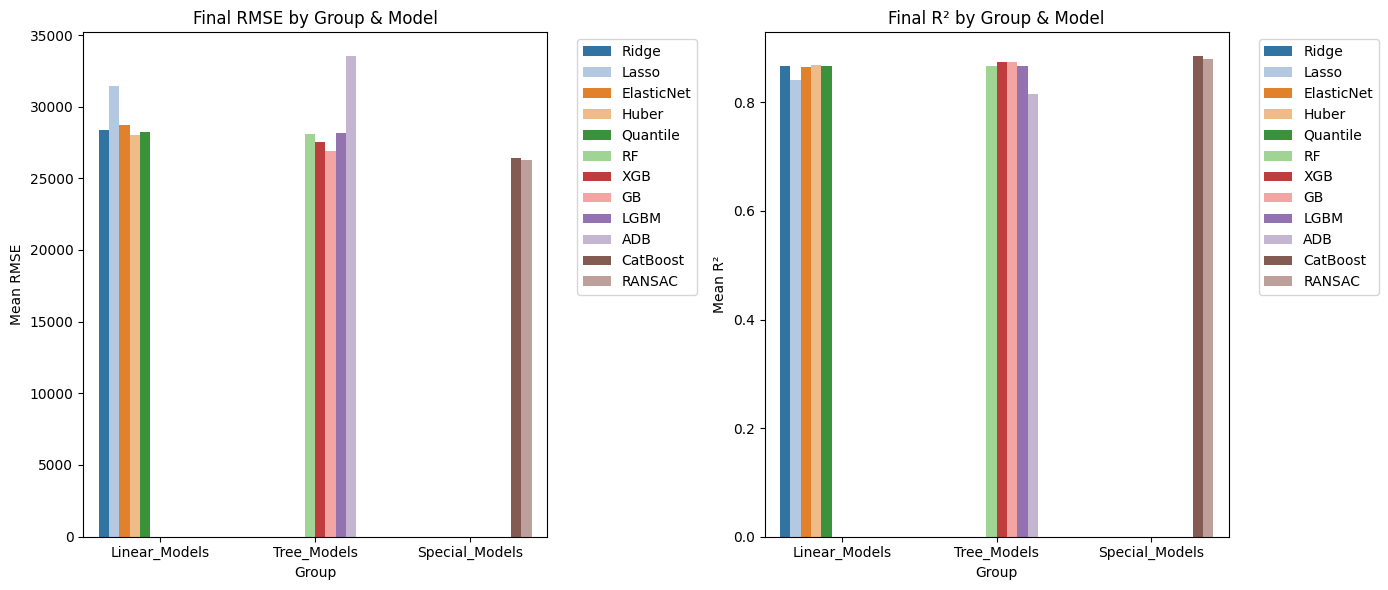

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

# RMSE
plt.subplot(1, 2, 1)
sns.barplot(data=final_results, x="Group", y="Mean_RMSE", hue="Model", palette="tab20")
plt.title("Final RMSE by Group & Model")
plt.ylabel("Mean RMSE")
plt.xticks(rotation=0)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# R²
plt.subplot(1, 2, 2)
sns.barplot(data=final_results, x="Group", y="Mean_R2", hue="Model", palette="tab20")
plt.title("Final R² by Group & Model")
plt.ylabel("Mean R²")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
save_df(final_results, "final_FS_results_preprocessing.xlsx", "results/experiments_results")

## Performance comparison

In [ ]:
results_all["Experiment"] = "Baseline"
final_results["Experiment"] = "Optimized"

preprocessing_comparison_df = pd.concat([results_all, final_results], ignore_index=True)

In [ ]:
# Tính RMSE trung bình theo Group + Model
pivot_rmse = preprocessing_comparison_df.pivot_table(
    index=["Group", "Model"],
    columns="Experiment",
    values="Mean_RMSE"
).round(5)

# Tính % cải thiện
pivot_rmse["Improve_%"] = (1 - pivot_rmse["Optimized"] / pivot_rmse["Baseline"]) * 100
pivot_rmse = pivot_rmse.sort_values(["Group", "Improve_%"], ascending=[True, False])

print("\n" + "="*90)
print("           SO SÁNH RMSE: BASELINE vs OPTIMIZED")
print("="*90)
print(pivot_rmse[["Baseline", "Optimized", "Improve_%"]])


           SO SÁNH RMSE: BASELINE vs OPTIMIZED
Experiment                    Baseline    Optimized  Improve_%
Group          Model                                          
Linear_Models  Ridge       35406.77857  28382.04263  19.840088
               ElasticNet  35372.74775  28687.70428  18.898853
               Huber       33032.56164  28020.47076  15.173183
               Quantile    32999.81811  28228.19288  14.459550
               Lasso       35591.48219  31424.84546  11.706837
Special_Models RANSAC      33251.67505  26256.29086  21.037690
               CatBoost    27735.81584  26429.47678   4.709936
Tree_Models    XGB         31872.48345  27560.92829  13.527516
               ADB         36995.81166  33510.57758   9.420618
               GB          29199.14428  26900.49549   7.872316
               RF          30339.99694  28095.65911   7.397291
               LGBM        29978.35793  28168.22405   6.038136


In [ ]:
# Trung bình % cải thiện theo nhóm
group_improve = pivot_rmse.groupby("Group")["Improve_%"].mean().round(2)

print("\n" + "="*70)
print("           TRUNG BÌNH CẢI THIỆN RMSE THEO NHÓM")
print("="*70)
for group, improve in group_improve.items():
    print(f"{group:<15}: +{improve:>5}%")


           TRUNG BÌNH CẢI THIỆN RMSE THEO NHÓM
Linear_Models  : +16.02%
Special_Models : +12.87%
Tree_Models    : + 8.85%


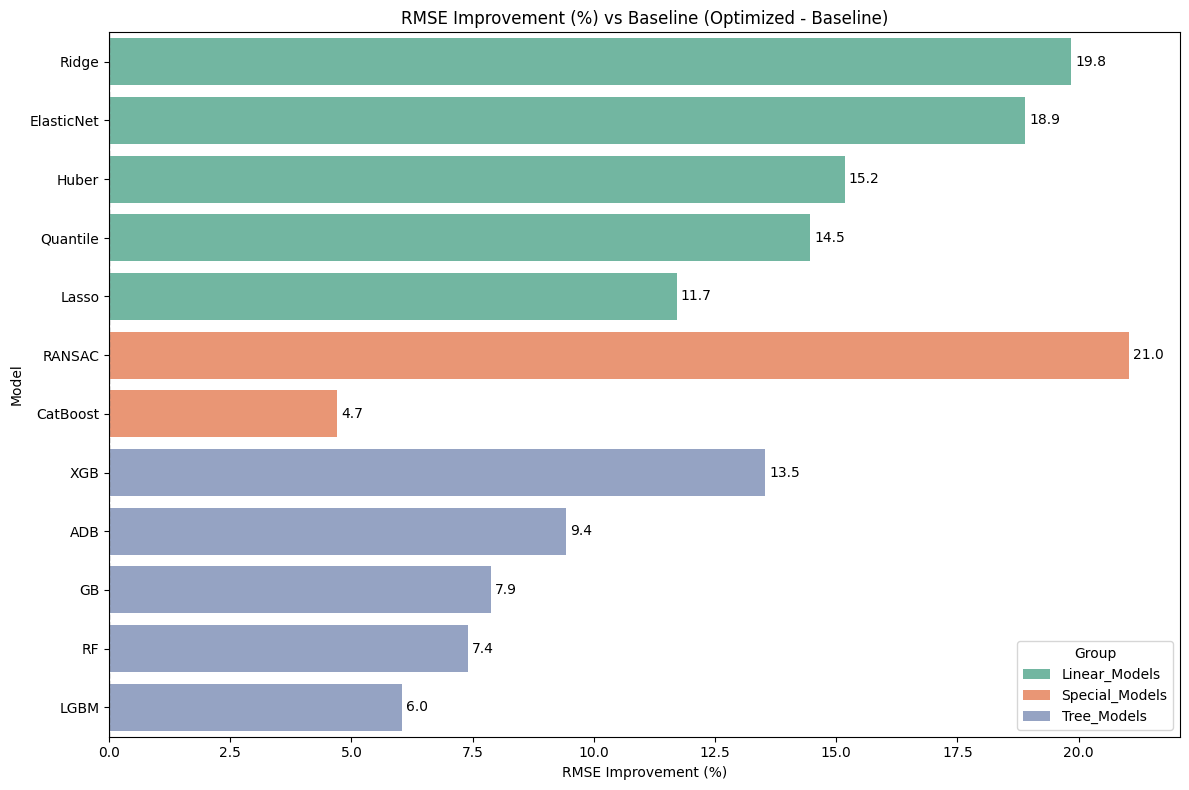

In [ ]:
# Heatmap cải thiện
plt.figure(figsize=(12, 8))
improve_pivot = pivot_rmse[["Improve_%"]].reset_index()
sns.barplot(
    data=improve_pivot,
    y="Model",
    x="Improve_%",
    hue="Group",
    palette="Set2",
    orient="h"
)

plt.title("RMSE Improvement (%) vs Baseline (Optimized - Baseline)")
plt.xlabel("RMSE Improvement (%)")
plt.ylabel("Model")

# Thêm đường dọc ở 0 để dễ so sánh tăng/giảm
plt.axvline(x=0, color='gray', linestyle='--', linewidth=1)

# Hiển thị giá trị trên cột
for container in plt.gca().containers:
    plt.bar_label(container, fmt="%.1f", padding=3)

plt.tight_layout()
plt.savefig("rmse_improvement_heatmap.png")
plt.show()

In [ ]:
# R²
pivot_r2 = preprocessing_comparison_df.pivot_table(
    index=["Group", "Model"],
    columns="Experiment",
    values="Mean_R2"
)
pivot_r2["R2_Diff"] = pivot_r2["Optimized"] - pivot_r2["Baseline"]

# Thời gian
pivot_time = preprocessing_comparison_df.pivot_table(
    index=["Group", "Model"],
    columns="Experiment",
    values="Mean_Time"
)
pivot_time["Time_Ratio"] = pivot_time["Optimized"] / pivot_time["Baseline"]

In [ ]:
summary_comparison = pd.DataFrame({
    "Group": pivot_rmse.index.get_level_values("Group"),
    "Model": pivot_rmse.index.get_level_values("Model"),
    "RMSE_Baseline": pivot_rmse["Baseline"],
    "RMSE_Optimized": pivot_rmse["Optimized"],
    "RMSE_Improve_%": pivot_rmse["Improve_%"],
    "R2_Baseline": pivot_r2["Baseline"],
    "R2_Optimized": pivot_r2["Optimized"],
    "R2_Improve": pivot_r2["R2_Diff"],
    "Time_Baseline": pivot_time["Baseline"],
    "Time_Optimized": pivot_time["Optimized"],
    "Time_Ratio": pivot_time["Time_Ratio"]
}).round(4)

print("\n" + "="*100)
print("           BẢNG TỔNG HỢP SO SÁNH CHI TIẾT")
print("="*100)
summary_comparison


           BẢNG TỔNG HỢP SO SÁNH CHI TIẾT


Group       Model  RMSE_Baseline  \
Group          Model                                                   
Linear_Models  ElasticNet   Linear_Models       Ridge     35372.7478   
               Huber        Linear_Models  ElasticNet     33032.5616   
               Lasso        Linear_Models       Huber     35591.4822   
               Quantile     Linear_Models    Quantile     32999.8181   
               Ridge        Linear_Models       Lasso     35406.7786   
Special_Models CatBoost    Special_Models      RANSAC     27735.8158   
               RANSAC      Special_Models    CatBoost     33251.6750   
Tree_Models    ADB            Tree_Models         XGB     36995.8117   
               GB             Tree_Models         ADB     29199.1443   
               LGBM           Tree_Models          GB     29978.3579   
               RF             Tree_Models          RF     30339.9969   
               XGB            Tree_Models        LGBM     31872.4834   

                           RMSE_Optimized  RMSE_Improve_%  R2_Baseline  \
Group          Model                                                     
Linear_Models  ElasticNet      28687.7043         18.8989       0.7895   
               Huber           28020.4708         15.1732       0.8156   
               Lasso           31424.8455         11.7068       0.7771   
               Quantile        28228.1929         14.4596       0.8103   
               Ridge           28382.0426         19.8401       0.7817   
Special_Models CatBoost        26429.4768          4.7099       0.8646   
               RANSAC          26256.2909         21.0377       0.8107   
Tree_Models    ADB             33510.5776          9.4206       0.7699   
               GB              26900.4955          7.8723       0.8441   
               LGBM            28168.2240          6.0381       0.8475   
               RF              28095.6591          7.3973       0.8392   
               XGB             27560.9283         13.5275       0.8218   

                           R2_Optimized  R2_Improve  Time_Baseline  \
Group          Model                                                 
Linear_Models  ElasticNet        0.8657      0.0762         0.1363   
               Huber             0.8688      0.0531         0.3102   
               Lasso             0.8417      0.0647         0.1309   
               Quantile          0.8675      0.0572         1.4141   
               Ridge             0.8666      0.0849         0.0461   
Special_Models CatBoost          0.8850      0.0204         5.8051   
               RANSAC            0.8794      0.0687         0.3615   
Tree_Models    ADB               0.8160      0.0462         0.5896   
               GB                0.8752      0.0311         0.9058   
               LGBM              0.8677      0.0202         0.2833   
               RF                0.8672      0.0280         3.1286   
               XGB               0.8751      0.0533         0.3814   

                           Time_Optimized  Time_Ratio  
Group          Model                                   
Linear_Models  ElasticNet          0.2484      1.8215  
               Huber               0.7049      2.2727  
               Lasso               0.4880      3.7285  
               Quantile            1.0178      0.7197  
               Ridge               0.3679      7.9834  
Special_Models CatBoost            8.2242      1.4167  
               RANSAC              0.4444      1.2291  
Tree_Models    ADB                 0.5067      0.8593  
               GB                  0.9153      1.0105  
               LGBM                1.0153      3.5839  
               RF                  2.1191      0.6773  
               XGB                 0.7724      2.0249

In [ ]:
save_df(summary_comparison, "comparison_preprocessing.xlsx", "results/experiments_results")

## Test for raw, FE, FE_FS data

In [ ]:
datasets = {
    "Raw": load_df("raw_data.csv"),
    "FE": load_df("FE_data.csv"),
    "FE+FS": load_df("FE_FS_data.csv")
}

results_final = []

print(f"\n{'='*100}")
print(f"  FINAL EVALUATION VỚI CÁC CONFIG TỐI ƯU TRÊN 3 DATASET")
print(f"{'='*100}")

for dataset_name, df in datasets.items():
    print(f"\n{'-'*80}")
    print(f"📊 Dataset: {dataset_name}")
    print(f"{'-'*80}")

    for group in model_groups.keys():
        print(f"\n→ Running {group} on {dataset_name}...")
        res = evaluate_dataset(
            df=df,
            dataset_name=dataset_name,
            base_models=base_models,
            model_groups=model_groups,
            group_name=group,
            config=None,
            n_splits=5,
            knn_neighbors=config["knn_neighbors"].get(group, 5),
            target_encoder_smoothing=config["target_encoder_smoothing"].get(group, 10)
        )
        res["Experiment"] = "Final"
        res["Dataset"] = dataset_name  # ✅ Ghi lại dataset đang dùng
        results_final.append(res)


# Gộp toàn bộ kết quả
final_results = pd.concat(results_final, ignore_index=True)

print(f"\n✅ Hoàn tất đánh giá trên {len(datasets)} bộ dữ liệu.")
print(f"Tổng số bản ghi kết quả: {len(final_results)}")

✅ Đã tải file CSV tại: /content/drive/MyDrive/Colab Notebooks/New Project 5/data/raw_data.csv
✅ Đã tải file CSV tại: /content/drive/MyDrive/Colab Notebooks/New Project 5/data/FE_data.csv
✅ Đã tải file CSV tại: /content/drive/MyDrive/Colab Notebooks/New Project 5/data/FE_FS_data.csv

  FINAL EVALUATION VỚI CÁC CONFIG TỐI ƯU TRÊN 3 DATASET

--------------------------------------------------------------------------------
📊 Dataset: Raw
--------------------------------------------------------------------------------

→ Running Linear_Models on Raw...

GROUP: Linear_Models | DATASET: Raw

Model: Ridge
   Fold 1 → RMSE=27637.67, R²=0.9004, Time=0.62s
   Fold 2 → RMSE=26334.99, R²=0.8980, Time=0.44s
   Fold 3 → RMSE=34593.80, R²=0.7834, Time=0.46s
   Fold 4 → RMSE=26920.23, R²=0.8846, Time=0.44s
   Fold 5 → RMSE=21787.96, R²=0.9092, Time=0.44s

Model: Lasso
   Fold 1 → RMSE=33046.99, R²=0.8576, Time=0.41s
   Fold 2 → RMSE=32909.56, R²=0.8407, Time=0.42s
   Fold 3 → RMSE=32995.16, R²=0.8029, T

In [ ]:
save_df(final_results, "final_dataset_after_preprocessing.xlsx", "results/experiments_results")